<a href="https://colab.research.google.com/github/vpste1/mlscrapbook/blob/master/MNISTLossFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.5MB/s 
     |████████████████████████████████| 1.1MB 15.6MB/s 
     |████████████████████████████████| 194kB 30.4MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

Load the training sets

In [5]:
train_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'3').ls()])
train_3_tens = train_3_tens.float()/255
train_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'train'/'7').ls()])
train_7_tens = train_7_tens.float()/255
train_3_tens.shape,train_7_tens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

Load the validation sets

In [6]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Stretch each 28x28 image into a 1x784 tensor, and stack them to form a rank 2 tensor with all images represented as rank 1 tensors.

Then generate a rank 1 tensor with all the y data (1 for threes and 0 for sevens).

Below we have 12396 images.

In [7]:
train_x = torch.cat([train_3_tens, train_7_tens]).view(-1, 28*28)
train_y = tensor([1]*train_3_tens.shape[0] + [0]*train_7_tens.shape[0]).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

Define a way to randomly initialise paramters (both weights and bias).

In [8]:
def init_params(size, variance=1.0): return (torch.randn(size)*variance).requires_grad_()

In [9]:
weights = init_params((28*28,1))

In [10]:
bias = init_params(1)

If we were to follow a linear model, and say `train_x@weights + bias` we would end up with a rank 1 tensor of all the different predictions for each image (12396x1 in size).

If we said any prediction greater than zero is a 3, and define our accuracy (traditionally a metric) as our loss function, we would find that small adjustments to paramters can result in nothing crossing the threshold, and the loss not changing. We essentially have a zero-gradient almost everywhere for this kind of loss function. 

We need a better representation of loss so that we can measure things more granularly heading in the right direction.

For the next section, we will be using smaller samples of data to demonstrate a better loss function. We have a target tensor, and a prediction tensor. The "closeness" of the prediction to the target is our loss:

In [11]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

`torch.where(a, b, c)` could be rewritten as `targets==1 ? 1-pred : pred`. We are essentially saying, if the target is 1, the loss should be its distance from one; otherwise its loss is the distance from 0.

In [12]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Tweaking our predictions to be closer to their targets will reduce the overall loss:

In [15]:
mnist_loss(tensor([0.9, 0.4, 0.99]),trgts)

tensor(0.1700)

Our current definition of `mnist_loss` relies on the predictions being between a 0 and a 1; something that a *sigmoid* can help translate our data to.

In [16]:
def sigmoid(x): return 1/(1+torch.exp(-x))

/usr/local/lib/python3.6/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


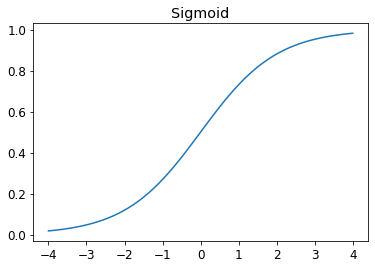

In [17]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

Let's update our definition of the `mnist_loss` function to take predictions and spread them between 0 and 1:

In [18]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Before moving forwards, a note on optimisation. If we were to calculate the loss of our model on the entire data set, it would be too slow. If we were to do it on a single item, we would only be gauging the models loss on that item. 

The best route is a compromise between the two: calculating the loss for a few titems at a time; known as a *mini-batch*. The number of items in a mini-batch is known as the batch size. A larger batch size results in a more stable estimate, but more time per epoch.

Batches can also be paralellised which is optimal for GPU processing.

We will also be shuffling our mini-batches each epoch to vary our data for better generalisation during training (avoiding over-fitting).

`DataLoaders` can do this shuffling and batching for us:

In [19]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

When training a model, we not only have inputs but we have their intended targets (X and Y). 

A collection that contains tuples of independent and dependent variables is known as a `Dataset`.

Here is a simple `Dataset`:

In [25]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [26]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]